Install and import dependencies

In [1]:
!pip install torch torchvision fastai onnx

     |████████████████████████████████| 7.4MB 8.2MB/s 


In [2]:
import os
import torch
import torch.onnx
import torchvision
import onnx
from fastai.vision import *
from fastai.metrics import accuracy
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Check GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Extract images from zip file

In [4]:
with zipfile.ZipFile("shamiko.zip") as f:
  f.extractall("data/shamiko")
with zipfile.ZipFile("momo.zip") as f:
  f.extractall("data/momo")


Inspect images

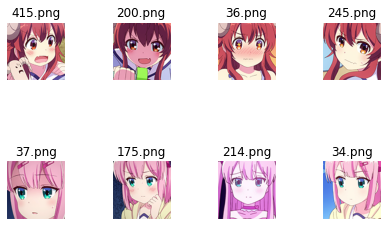

In [5]:
im_folders = [
              "data/shamiko",
              "data/momo"
]
fig, ax = plt.subplots(nrows=2, ncols=4)
fig.tight_layout()
for i, row in enumerate(ax):
  for col in row:
    im_path = im_folders[i]
    im_name = np.random.choice(os.listdir(im_path))
    im = Image.open(os.path.join(im_path, im_name))
    col.imshow(im)
    col.set_title(im_name)
    col.axis("off")

plt.show()

Create training and validation sets

In [6]:
im_data = ImageDataBunch.from_folder(
    "data",
    ds_tfms=get_transforms(do_flip=True, flip_vert=True),
    valid_pct=0.3,
    size=224,
    bs=64,
)
im_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (751 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
momo,momo,momo,momo,momo
Path: data;

Valid: LabelList (321 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
shamiko,momo,shamiko,momo,shamiko
Path: data;

Test: None

Create learner

In [7]:
learner = cnn_learner(
    im_data,
    models.resnet18,
    metrics=[accuracy],
    callback_fns=ShowGraph,
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Fit Model and Graph Loss

epoch,train_loss,valid_loss,accuracy,time
0,0.518091,0.091232,0.959502,00:07
1,0.267305,0.081175,0.978193,00:06
2,0.164311,0.081863,0.981308,00:06
3,0.117352,0.065030,0.984424,00:06
4,0.086062,0.059640,0.984424,00:06
5,0.071091,0.047483,0.990654,00:06
6,0.057310,0.044997,0.990654,00:07
7,0.050551,0.039688,0.990654,00:06


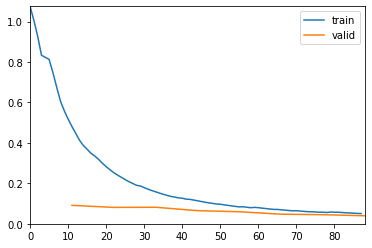

In [8]:
learner.fit_one_cycle(8)

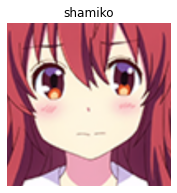

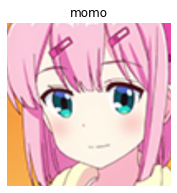

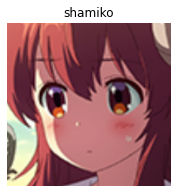

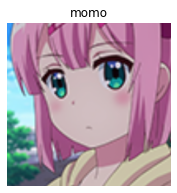

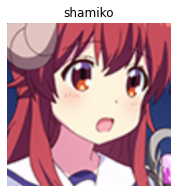

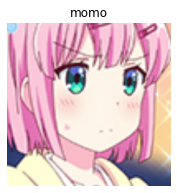

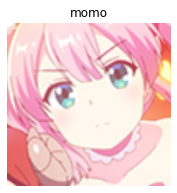

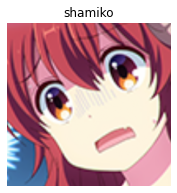

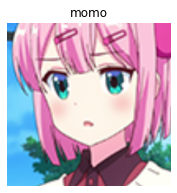

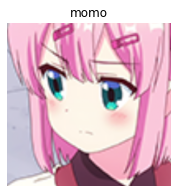

In [22]:
for i in range(10):
  test_im, correct = im_data.valid_ds[i]
  prediction = learner.predict(test_im)
  test_im.show(y=prediction[0])

Export to ONNX

In [29]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
input_names = [ "actual_input" ]
output_names = [ "output" ]

# Add softmax layer
model = list(learner.model.children()) + [nn.Softmax(dim=0)]
model = nn.Sequential(*model)
model.eval()

torch.onnx.export(
    model,
    dummy_input,
    "final_model.onnx",
    input_names=input_names,
    output_names=output_names,
)